In [12]:
# Import
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier

In [13]:
# Load the Dataset
df = pd.read_csv("./../../Dataset/Final-dataset-binary/transformers.csv")

In [14]:
print(df.isnull().sum())

version           0
path              0
file_type         0
line_count        0
method_count      0
coupling_score    0
has_smell         0
dtype: int64


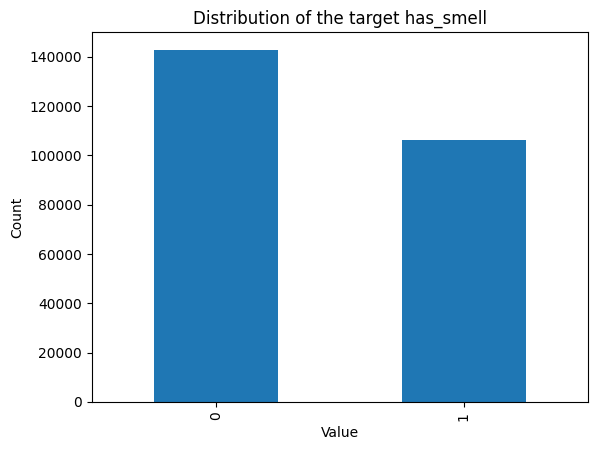

In [15]:
df["has_smell"].value_counts().plot(kind="bar")
plt.title("Distribution of the target has_smell")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

In [16]:
# Encoding categorical data
categorical_features = ["version", "path", "file_type"]
numerical_features = ["line_count", "method_count", "coupling_score"]
target_feature = "has_smell"

# Preprocessing
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = onehot_encoder.fit_transform(df[categorical_features])

X_num = df[numerical_features].values

X_combined = np.concatenate([X_cat, X_num], axis=1)
y = df[target_feature].values

In [17]:
# Splitting the dataset into the Training set and the Test set
split_idx = int(0.8 * len(df))
X_train, X_test = X_combined[:split_idx], X_combined[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [18]:
# Feature scaling
num_start = X_cat.shape[1]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# ANN Model

In [19]:
ann_model = tf.keras.models.Sequential()
ann_model.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann_model.add(tf.keras.layers.Dropout(0.3))
ann_model.add(tf.keras.layers.Dense(units=32, activation='relu'))
ann_model.add(tf.keras.layers.Dropout(0.3))
ann_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [20]:
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
ann_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[callback])

Epoch 1/100
4982/4982 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8963 - loss: 0.2275 - val_accuracy: 0.8873 - val_loss: 0.6703
Epoch 2/100
4982/4982 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9828 - loss: 0.0437 - val_accuracy: 0.8882 - val_loss: 0.8777
Epoch 3/100
4982/4982 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9885 - loss: 0.0291 - val_accuracy: 0.8901 - val_loss: 0.7438
Epoch 4/100
4982/4982 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9915 - loss: 0.0216 - val_accuracy: 0.8877 - val_loss: 0.9780
Epoch 5/100
4982/4982 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9930 - loss: 0.0180 - val_accuracy: 0.8879 - val_loss: 1.2441
Epoch 6/100
4982/4982 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9950 - loss: 0.0132 - val_accuracy: 0.8874 - val_loss: 1.5231
Epoch 7/100
4982/4982 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9960 - loss: 0.0101 - val_accuracy: 0.8866 - val_loss: 1.4418
Epoch 8/100
4982/4982 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9962 - los

In [22]:
y_pred_ann = (ann_model.predict(X_test) > 0.5).astype(int).flatten()
print("Accuracy:", accuracy_score(y_test, y_pred_ann))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ann))
print("Classification Report:\n", classification_report(y_test, y_pred_ann))

1557/1557 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step
Accuracy: 0.8555254441433303
Confusion Matrix:
 [[24614  1572]
 [ 5625 18004]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87     26186
           1       0.92      0.76      0.83     23629

    accuracy                           0.86     49815
   macro avg       0.87      0.85      0.85     49815
weighted avg       0.86      0.86      0.85     49815



# Random Forest Model

In [23]:
forest_model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
forest_model.fit(X_train, y_train)
y_pred_forest = forest_model.predict(X_test)

In [24]:
print("Accuracy:", accuracy_score(y_test, y_pred_forest))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_forest))
print("Classification Report:\n", classification_report(y_test, y_pred_forest))

Accuracy: 0.8613670581150256
Confusion Matrix:
 [[24595  1591]
 [ 5315 18314]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.94      0.88     26186
           1       0.92      0.78      0.84     23629

    accuracy                           0.86     49815
   macro avg       0.87      0.86      0.86     49815
weighted avg       0.87      0.86      0.86     49815



# Code Stacking (SVR)

In [25]:
# Créer les ebtrées du modèle d'ensemble (stacking)
ann_preds = ann_model.predict(X_test).flatten()
forest_preds = forest_model.predict(X_test)
stacked_inputs = np.column_stack((ann_preds, forest_preds))

1557/1557 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step


In [26]:
# Entrîner le modèle méta (SVR)
meta_model = SVR()
meta_model.fit(stacked_inputs, y_test)

,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [27]:
# Prédictions finales
final_preds = meta_model.predict(stacked_inputs)

In [28]:
# Evaluation
mse = mean_squared_error(y_test, final_preds)
print("MSE du modèle de stacking (SVR):", mse)
print("Prédictions (extrait):", final_preds[:10])

MSE du modèle de stacking (SVR): 0.10344769392888369
Prédictions (extrait): [0.90029503 0.90029527 0.10048863 0.10036142 0.10037865 0.10312759
 0.46954194 0.10056162 0.90029445 0.90029455]


In [29]:
final_preds_binary = (final_preds >= 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, final_preds_binary)
print("Accuracy stacking SVR :", accuracy)

# Evaluation complète
print("Confusing Maxtric:\n", confusion_matrix(y_test, final_preds_binary))
print("Classification Report:\n", classification_report(y_test, final_preds_binary))

Accuracy stacking SVR : 0.8785907859078591
Confusing Maxtric:
 [[24206  1980]
 [ 4068 19561]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89     26186
           1       0.91      0.83      0.87     23629

    accuracy                           0.88     49815
   macro avg       0.88      0.88      0.88     49815
weighted avg       0.88      0.88      0.88     49815

